In [7]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()

print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

spark = SparkSession.builder.appName('mlonspark')\
    .config('spark.executor.instances', '7')\
    .getOrCreate()

print('pyspark ready ...')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...
pyspark ready ...


In [8]:
from pyspark.ml.recommendation import ALS
def initalg(val):
    return ALS()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("listenCount")\
    .setMaxIter(val)\
    .setRank(40)\
    .setImplicitPrefs(True)


In [9]:
train = spark.read.load("/data/lastfm-dataset-360K/data-filtered-train.parquet")
test = spark.read.load("/data/lastfm-dataset-360K/data-filtered-test.parquet")

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setLabelCol("listenCount")\
    .setPredictionCol("prediction")

def runtest(rng, **model_kargs):
    res = []
    for i in rng:
        alg = initalg(i)
        model = alg.fit(train)
        trainPredictions = model.transform(train)
        trainPredictionsFiltered = trainPredictions.where(~isnan(col("prediction")))  
        trainRmse = evaluator.evaluate(trainPredictionsFiltered)
        testPredictions = model.transform(test)
        testPredictionsFiltered = testPredictions.where(~isnan(col("prediction")))    
        testRmse = evaluator.evaluate(testPredictionsFiltered)
        res.append([i, trainRmse, testRmse])
    return res

In [11]:
import numpy as np
rng = np.arange(1, 20, 2).tolist()
res = runtest(rng)
print(res)

[[1, 212.36851062840432, 212.93782946847497], [3, 212.15677361448212, 212.58877409545994], [5, 212.14646898895853, 212.5659206716582], [7, 212.1434555161872, 212.56020161490784], [9, 212.14211257384437, 212.5582060601257], [11, 212.14135488101982, 212.55732975859777], [13, 212.1408543027095, 212.5568542373628], [15, 212.1404857879331, 212.55654030889792], [17, 212.14019350958722, 212.5562983297059], [19, 212.1399495459248, 212.55609230385775]]


Text(0, 0.5, 'RMSE')

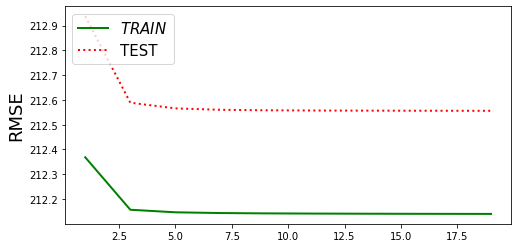

In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

x = []
yTrain = []
yTest = []
for v in res:
    x.append(v[0])
    yTrain.append(v[1])
    yTest.append(v[2])

plt.figure(figsize=(8,4))
plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
plt.legend(loc="upper left", fontsize=15)
plt.ylabel("RMSE", fontsize=18)